<a href="https://colab.research.google.com/github/giacomo-monni/ML_Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and packages

Importing necessary Python packages to process the data.

In [ ]:
!pip install tld
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Dataset Management packages
import numpy as np
import pandas as pd

import os
import string

# Packeges to get Google Drive access
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import re
from tld import get_tld, is_tld
from urllib.parse import urlparse
import tldextract
import hashlib
import joblib

from wordcloud import WordCloud
# Plotting packages
import matplotlib.pyplot as plt
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
# Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Performance evaluation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

# Some libraries useful for classification purposes
from sklearn.pipeline import make_pipeline # to create a pipeline for SGD
from sklearn.preprocessing import StandardScaler

# Loading the Dataset
The Malicious URL's Dataset is composed of:
- Benign/safe URLs
- Defacement URLs
- Phishing URLs
- Malware URLs

The dataset (downloaded from https://www.kaggle.com/datasets/naveenbhadouria/malicious/code) has been stored into my Google Drive.

In order to obtain the file, the PyDrive2 package has been used: it allows to authenticate to Google Drive and obtain the file starting from its ID.

The downloaded dataset from Google Drive (.csv) is then handled with Pandas.



In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# File ID on Google Drive
file_id = '1iBTfKOyuwL-S-bkLKkjmCgdAih9XCxSR'

# Obtaining the file with the specified ID
# and downloading the file to a local path
drive_file = drive.CreateFile({'id': file_id})
drive_file.GetContentFile('malicious_phish1.csv')

# Reading the .csv file
urls_data = pd.read_csv('malicious_phish1.csv')
print(urls_data.head())

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


# Data Preprocessing and Analyzing Data
Processing the URLs of the dataset, and extracting useful information in order to be classified.

- Removing "www." from each URL
- Assigning a label for each url type of URL
    - 'benign' -> 0
    - 'defacement' -> 1
    - 'phishing' -> 2
    - 'malware' -> 3
- Primary Domain
- URL length
- Number of letters, digits and special characters
- URL region
- HTTPS?
- Shortening URL service used?

In [ ]:
# @title Removing "www." and assigning a label to each URL type
print(urls_data)

# Removing "www." from URLs
urls_data['url'] = urls_data['url'].replace('www.', '', regex=True)

# Applying a label to each URL
#   - 'benign' -> 0
#   - 'defacement' -> 1
#   - 'phishing' -> 2
#   - 'malware' -> 3
urls_data['label'] = urls_data['type'].replace({'benign':0, 'defacement':1,
                                                'phishing':2,'malware':3})

                                                      url        type  label
0                                        br-icloud.com.br    phishing      2
1                     mp3raid.com/music/krizz_kaliko.html      benign      0
2                         bopsecrets.org/rexroth/cr/1.htm      benign      0
3       http://garage-pirenne.be/index.php?option=com_...  defacement      1
4       http://adventure-nicaragua.net/index.php?optio...  defacement      1
...                                                   ...         ...    ...
651186            xbox360.ign.com/objects/850/850402.html    phishing      2
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing      2
651188             gamespot.com/xbox360/action/deadspace/    phishing      2
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing      2
651190              angelfire.com/goth/devilmaycrytonite/    phishing      2

[651191 rows x 3 columns]


<ipython-input-10-8701d651eb66>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  urls_data['label'] = urls_data['type'].replace({'benign':0, 'defacement':1,


### Primary Domains from URLs

In [ ]:
def extract_primary_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=True)
        primary_domain = res.parsed_url.netloc
    except :
        primary_domain = None
    return primary_domain



### URLs Length

In [ ]:
def get_url_length(url):
    # Protocol prefixes
    prefixes = ['http://', 'https://']

    for protocol in prefixes:
        if url.startswith(protocol):
            # Taking URL length only, not taking into account the protocol
            url = url[len(protocol):]

    return len(url)

### Counting letters, digits and special characters

In [ ]:
def count_letters(url):
    return sum(char.isalpha() for char in url)

def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_characters(url):
    # Creating a set with all the punctuation characters, i.e. !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    special_characters = set(string.punctuation)
    return sum(char in special_characters for char in url)

### URL region

In [ ]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }

    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]

    return "Global"

### HTTP or HTTPS

In [ ]:
def is_https(url):
    # Returns 1 if the url contains https
    return int(urlparse(url).scheme == 'https')

### Shortening URL used

In [ ]:
def has_shortening_service(url):
    # Regex pattern to extract the main domain
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)

    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping',
                                      'post', 'Just', 'bkite', 'snipr', 'fic',
                                      'loopt', 'doiop', 'short', 'kl', 'wp',
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd',
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur',
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is',
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl',
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro',
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url',
                                      'tweez', 'v', 'tr', 'link', 'zip']
        # Returns 1 if the url is shortened
        if domain.lower() in common_shortening_services:
            return 1
    return 0

### Abnormal URL

In [ ]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0

### Have IP

In [ ]:
import ipaddress
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

### Root Domain

In [ ]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

### Extraction

In [ ]:
urls_data['primary_domain'] = urls_data['url'].apply(lambda x: extract_primary_domain(x))
urls_data['url_length'] = urls_data['url'].apply(lambda x: get_url_length(x))

urls_data['n_letters'] = urls_data['url'].apply(lambda x: count_letters(x))
urls_data['n_digits'] = urls_data['url'].apply(lambda x: count_digits(x))
urls_data['n_special_chars'] = urls_data['url'].apply(lambda x: count_special_characters(x))

urls_data['region'] = urls_data['url'].apply(lambda x: get_url_region(x))
urls_data['https'] = urls_data['url'].apply(lambda x: is_https(x))
urls_data['shortened'] = urls_data['url'].apply(lambda x: has_shortening_service(x))
urls_data['abnormal_url'] = urls_data['url'].apply(lambda x: abnormal_url(x))
urls_data['have_ip'] = urls_data['url'].apply(lambda x: have_ip_address(x))
urls_data['root_domain'] = urls_data['url'].apply(lambda x: extract_root_domain(x))

urls_data.head()

,url,type,label,primary_domain,url_length,n_letters,n_digits,n_special_chars,region,https,shortened,abnormal_url,have_ip,root_domain
0,br-icloud.com.br,phishing,2,br-icloud.com.br,16,13,0,3,Brazil,0,0,0,0,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,mp3raid.com,35,29,1,5,Global,0,0,0,0,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,bopsecrets.org,31,25,1,5,Global,0,0,0,0,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,garage-pirenne.be,77,60,7,17,Global,0,0,1,0,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,adventure-nicaragua.net,228,199,22,14,Global,0,0,1,0,adventure-nicaragua


# Some statics about the dataset

In [ ]:
# @title Plotting the nature of the URLs
count = urls_data['type'].value_counts()
colors = [
    '#00FF33', '#FF6633', '#AA00AA', '#FF0000']
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))],
                layout=go.Layout(height=800, width=1000))
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)
fig.update_xaxes(tickfont=dict(color='black'), gridcolor='black')
fig.update_yaxes(tickfont=dict(color='black'), gridcolor='black')
fig.show()

In [ ]:
# @title Pie chart based on the label of the URLs
label_counts = urls_data['label'].value_counts()
fig = go.Figure(data=[go.Pie(labels=label_counts.index, values=label_counts.values)],
                layout=go.Layout(height=800, width=1000))
fig.update_layout(title='Distribution of Labels',
                  template='presentation',
                  font=dict(color='black'),
                  showlegend=True)
fig.show()

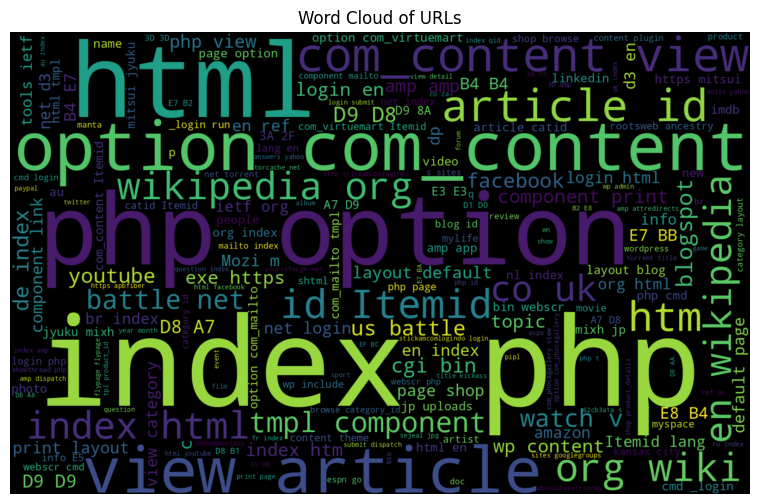

In [ ]:
# @title Word Cloud of URLs
# Most present words in URLs
wordcloud = WordCloud(width=1600, height=1000, background_color='black').generate(' '.join(urls_data['url']))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

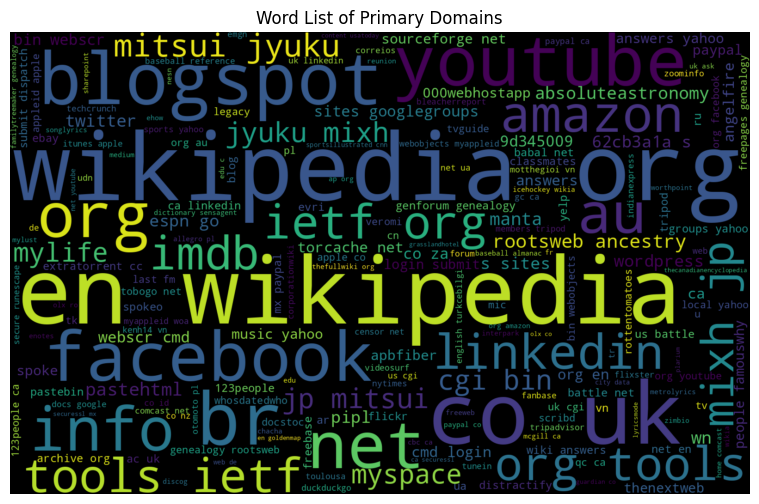

In [ ]:
# @title Word List of Primary Domains
# Wordlist after removing None values from the primary domains
wordcloud = WordCloud(width=1600, height=1000, background_color='black').generate(' '.join(urls_data['primary_domain'].dropna()))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word List of Primary Domains')
plt.show()

In [ ]:
# @title Histogram on URL length

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Histogram(x=urls_data['url_length'], nbinsx=100))

fig.update_layout(
    title='Histogram of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
    template='presentation',
    font=dict(color='black')
)

fig.show()

In [ ]:
# @title Bar chart for the number of letters, numbers and special characters
counts=urls_data[['n_letters', 'n_digits', 'n_special_chars']].sum()

fig = go.Figure(data=[
    go.Bar(name='Letters', x=['Count'], y=[counts['n_letters']]),
    go.Bar(name='Digits', x=['Count'], y=[counts['n_digits']]),
    go.Bar(name='Special Characters', x=['Count'], y=[counts['n_special_chars']])],
    layout=go.Layout(height=700, width=1000)
    )

fig.update_layout(
    title='Counts of letters, digits and special characters',
    xaxis_title='Type',
    yaxis_title='Count',
    template='presentation',
    font=dict(color='black')
)

fig.show()

## Further preprocessing of data
Since "root_domain"and "region" features are represented by strings, but classifiers need numerical types to perform classifications, these two values are changed by computing an integer hash

In [ ]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [ ]:
data = urls_data.drop(columns=['url','type','primary_domain'])

data = data[data['root_domain'] != '0']
data['root_domain'].value_counts()

# applying hashes to root_domain and regions in order to identify uniquely
# identify them by transforming them into numbers instead of strings
data['root_domain'] = data['root_domain'].apply(hash_encode)
data['region'] = data['region'].apply(hash_encode)

data.head()

,label,url_length,n_letters,n_digits,n_special_chars,region,https,shortened,abnormal_url,have_ip,root_domain
0,2,16,13,0,3,27739261,0,0,0,0,1310791
1,0,35,29,1,5,32604616,0,0,0,0,58335668
2,0,31,25,1,5,32604616,0,0,0,0,28611805
3,1,77,60,7,17,32604616,0,0,1,0,89045308
4,1,228,199,22,14,32604616,0,0,1,0,76838614


# Classification
Using __Stochastic Gradient Descent (SGD)__, __Random Forest__ classifiers and building a __Dense Neural Network__.


In [ ]:
x = data.drop(columns=['label']) # feature set
y = data['label'] # labels

## Classifiers
__SGD__ and __RF__

In [ ]:
# Stochastic Gradient Descent
sgd = make_pipeline(StandardScaler(), SGDClassifier(loss='hinge',penalty='l2',
                                                    alpha=1e-3, max_iter=1000,
                                                    random_state=42, tol=1e-4))

# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

# Building a list containing the two selected classifiers
clfs = [sgd, rf]
clfs_labels = ['SGD', 'RF']

# k-fold cross-validation
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

Defining a function for performance evaluation applicable to every classifier.
The average parameter of the `precision_score` and `f1_score` functions is set to `'weighted'` since this is a __multiclass__ problem since the dataset is unbalanced (many more benign URLs than other categories)

In [ ]:
# Defining a function to evaluate metrics and calculate the confusion matrix
def evaluate_model(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, f1, conf_matrix

In [ ]:
# dictionary for the results of each classifier
clfs_results = {}
for clf, clf_label in zip(clfs, clfs_labels):
    accuracy = []       # accuracy metric
    precision = []      # precision score
    f1 = []             # f1 score
    conf_matrices = []  # saving confusion matrices for each split
    # performing KFold
    for train_idx, test_idx in splitter.split(x):
        x_train_k, x_test_k = x.iloc[train_idx], x.iloc[test_idx]
        y_train_k, y_test_k = y.iloc[train_idx], y.iloc[test_idx]

        metrics = evaluate_model(clf, x_train_k, y_train_k, x_test_k, y_test_k)
        # Saving metrics
        accuracy.append(metrics[0])
        precision.append(metrics[1])
        f1.append(metrics[2])
        conf_matrices.append(metrics[3]) # Confusion Matrix

    # Saving average results and the average confusion matrix for the classifier
    avg_accuracy = np.mean(accuracy)
    avg_precision = np.mean(precision)
    avg_f1_score = np.mean(f1)
    avg_conf_matrix = np.mean(conf_matrices, axis=0)

    clfs_results[clf_label] = {
        'avg_accuracy': avg_accuracy,
        'avg_precision': avg_precision,
        'avg_f1_score': avg_f1_score,
        'avg_conf_matrix': avg_conf_matrix
    }

In [ ]:
#@title Printing results
for clf_label, result in clfs_results.items():
    print(f'CLASSIFIER: {clf_label}')
    print(f"Average Accuracy: {100*result['avg_accuracy']:.4f}%")
    print(f"Average Precision: {100*result['avg_precision']:.4f}%")
    print(f"Average F1-score: {100*result['avg_f1_score']:.4f}%")
    print('Confusion matrix for each split:')
    for k_split, matrix in enumerate(conf_matrices, start=1):
        print(f'Split {k_split}\n{matrix}')
        print('\n')
    print(f"Average Confusion Matrix:")
    print(f"{result['avg_conf_matrix']}")
    print('\n\n\n')

CLASSIFIER: SGD
Average Accuracy: 79.2841%
Average Precision: 79.6773%
Average F1-score: 74.3026%
Confusion matrix for each split:
Split 1
[[41946   727    54     0]
 [  707  8867     9    13]
 [ 5157  1222  2991    68]
 [  248   545   141  2424]]


Split 2
[[42137   774    67     0]
 [  663  8888    12    11]
 [ 5071  1217  2956    71]
 [  235   534   139  2344]]


Split 3
[[42087   633    60     6]
 [  731  8864    11    20]
 [ 5150  1164  3113    80]
 [  236   486   117  2361]]


Split 4
[[42199   626    68     1]
 [  746  8824    12    22]
 [ 5210  1134  3007    73]
 [  228   523   121  2325]]


Split 5
[[42121   687    61     5]
 [  726  8926    13    14]
 [ 5124  1129  3010    66]
 [  195   543   124  2375]]


Split 6
[[41931   681    66     0]
 [  723  9114    16    16]
 [ 5196  1203  2947    64]
 [  225   517   141  2279]]


Split 7
[[41952   698    60     1]
 [  673  8989    11    11]
 [ 5157  1145  3048    62]
 [  224   546   126  2415]]


Split 8
[[42055   703    57     2]
 

## Classifiers results
In this section we will see the results, in terms of classification report and confusion matrix of each classifier, in each split done.

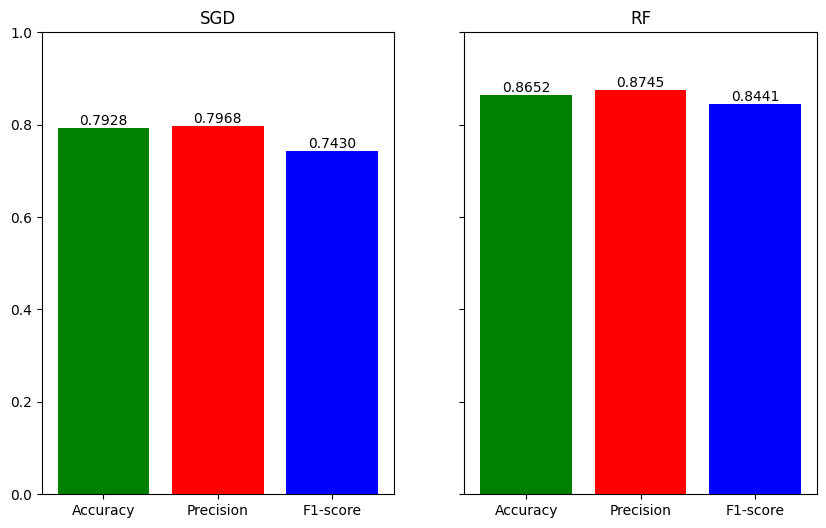

<Figure size 800x500 with 0 Axes>

In [ ]:
# Extracting plotting data
classifiers = list(clfs_results.keys())
avg_accuracies = [clfs_results[clf]['avg_accuracy'] for clf in classifiers]
avg_precisions = [clfs_results[clf]['avg_precision'] for clf in classifiers]
avg_f1_scores = [clfs_results[clf]['avg_f1_score'] for clf in classifiers]

x = np.arange(len(classifiers))
width = 0.2
fig, axes_metrics = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(10, 6), sharey='row')
plt.figure(figsize=(8, 5))

for i, clf in enumerate(classifiers):
    # Create a subplot for the specific data representation and classifier
    ax = axes_metrics[i]

    # Plot the metrics
    ax.bar(['Accuracy','Precision', 'F1-score'], [avg_accuracies[i], avg_precisions[i], avg_f1_scores[i]], color=['green', 'red', 'blue'])

    # Set the subplot title and limits
    ax.set_title(f'{clf}')
    ax.set_ylim(0, 1)

    # Annotate bars with metric values
    for x, val in enumerate([avg_accuracies[i], avg_precisions[i], avg_f1_scores[i]]):
        ax.annotate(f'{val:.4f}', (x, val), ha='center', va='bottom')


plt.tight_layout()
plt.show()

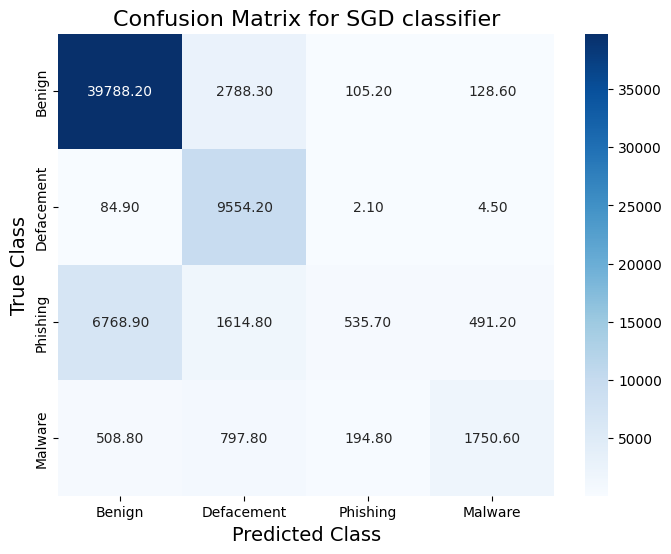

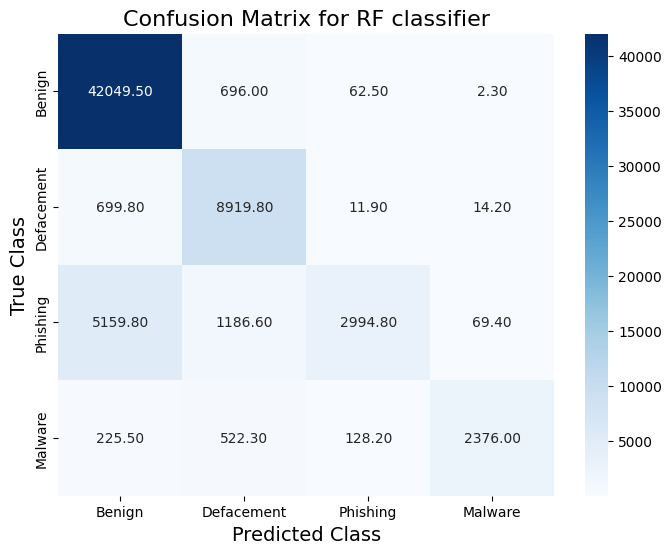

In [ ]:
#@title Plotting the Confusion Matrix for the classifiers
classes = ['Benign', 'Defacement', 'Phishing', 'Malware']

for clf_label, result in clfs_results.items():
    avg_conf_matrix = result['avg_conf_matrix']
    plt.figure(figsize=(8,6))
    sns.heatmap(avg_conf_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes,
                yticklabels=classes)
    plt.title(f'Confusion Matrix for {clf_label} classifier', fontsize=16)
    plt.xlabel('Predicted Class', fontsize=14)
    plt.ylabel('True Class', fontsize=14)
    plt.show()

## Dense Neural Network


In [ ]:
#@title Preprocessing data for the Neural Network
# training and test set splitting
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='label'), data['label'], test_size=0.2, random_state=42)

# training and test samples (pandas DataFrames) are normalized
# with the StandardScaler in order to be converted to Pytorch tensors
scaler = StandardScaler()
x_train_nn = scaler.fit_transform(x_train)  # Fit on train, transform train
x_test_nn = scaler.transform(x_test)       # Transform test


# Converting labels to Pytorch tensors
y_train_nn = torch.tensor(y_train.values, dtype=torch.long)
y_test_nn  = torch.tensor(y_test.values, dtype=torch.long)

# Converting features to Pytorch tensors
x_train_tensor = torch.tensor(x_train_nn, dtype=torch.float32)
x_test_tensor  = torch.tensor(x_test_nn, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset_nn = TensorDataset(x_train_tensor, y_train_nn)
test_dataset_nn = TensorDataset(x_test_tensor, y_test_nn)

train_loader_nn = DataLoader(dataset=train_dataset_nn,
                             batch_size=256,
                             shuffle=True)
test_loader_nn = DataLoader(dataset=test_dataset_nn,
                            batch_size=256,
                            shuffle=False)

## Defining a class for the Dense Neural Network
It is compesed of three hidden layers, each of which apply an affine linear transformation to the incoming data: \begin{equation}y = xA^T + b\end{equation}
Then it applies the ReLU (Rectified Linear Unit) function element-wise:
\begin{equation}ReLU(x) = (x)^+ = max(0,x)\end{equation}
Finally, applies the Softmax function which rescales the input tensor so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.
\begin{equation}Softmax(x_i​)=\frac{exp(x_i)}{∑_j ​exp(x_j​)}​\end{equation}

In [ ]:
class DenseNN(nn.Module):
    def __init__(self, n_classes=4):
        super(DenseNN, self).__init__()
        self.fc1 = nn.Linear(in_features=10, out_features=64) # 1st layer
        self.fc2 = nn.Linear(in_features=64, out_features=32) # 2nd layer
        self.fc3 = nn.Linear(in_features=32, out_features=4)  # 3rd layer
        self.relu = nn.ReLU() # ReLU Activaction
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

In [ ]:
# Instantiating the network
dnn = DenseNN()

### Training the Dense Neural Network
Learning Rate is set to 0.001; it is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving towards a minimum of a loss function

In [ ]:
learning_rate = 0.001
n_epochs = 10 # training epochs

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr=learning_rate)

total_step = len(train_loader_nn)
loss_path = np.zeros(shape=(n_epochs,total_step))
for epoch in range(n_epochs):
    dnn.train()
    for i, (x_batch, y_batch) in enumerate(train_loader_nn):
        outputs = dnn(x_batch) # Forward pass
        loss = criterion(outputs, y_batch) # Compute Loss

        loss_path[epoch][i] = loss.item()

        optimizer.zero_grad() # resets the gradients
        loss.backward()
        optimizer.step() # update weights
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, n_epochs, i+1, total_step, loss.item()))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/10], Step [100/2035], Loss: 0.9788
Epoch [1/10], Step [200/2035], Loss: 0.9935
Epoch [1/10], Step [300/2035], Loss: 0.9467
Epoch [1/10], Step [400/2035], Loss: 0.9633
Epoch [1/10], Step [500/2035], Loss: 0.9223
Epoch [1/10], Step [600/2035], Loss: 0.9518
Epoch [1/10], Step [700/2035], Loss: 0.9279
Epoch [1/10], Step [800/2035], Loss: 0.9448
Epoch [1/10], Step [900/2035], Loss: 0.9214
Epoch [1/10], Step [1000/2035], Loss: 0.9361
Epoch [1/10], Step [1100/2035], Loss: 0.9225
Epoch [1/10], Step [1200/2035], Loss: 0.9577
Epoch [1/10], Step [1300/2035], Loss: 0.9152
Epoch [1/10], Step [1400/2035], Loss: 0.8794
Epoch [1/10], Step [1500/2035], Loss: 0.9396
Epoch [1/10], Step [1600/2035], Loss: 0.9014
Epoch [1/10], Step [1700/2035], Loss: 0.8974
Epoch [1/10], Step [1800/2035], Loss: 0.9633
Epoch [1/10], Step [1900/2035], Loss: 0.9117
Epoch [1/10], Step [2000/2035], Loss: 0.9679
Epoch [2/10], Step [100/2035], Loss: 0.9039
Epoch [2/10], Step [200/2035], Loss: 0.9321
Epoch [2/10], Step [3

In [ ]:
#@title Testing the model
dnn.eval()

predictions = []
labels = []

with torch.no_grad():
    for x, label in test_loader_nn:
        outputs = dnn(x)
        # Predicted Class
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted)
        labels.append(label)

# Concatenate all predictions and labels into single tensors
predictions = torch.cat(predictions)
labels = torch.cat(labels)

# Conversion to NumPy arrays for compatibility with Scikit-learn
predictions_np = predictions.cpu().numpy()
labels_np = labels.cpu().numpy()

# Metrics computation
accuracy_dnn = accuracy_score(labels_np, predictions_np)
precision_dnn = precision_score(labels_np, predictions_np, average='weighted')
f1_score_dnn = f1_score(labels_np, predictions_np, average='weighted')

# Confusion Matrix computation
confusion_matrix_dnn = confusion_matrix(labels, predictions)

print(f"Accuracy of the DNN: {100*accuracy_dnn:.4f} %")
print(f"Precision of the DNN: {100*precision_dnn:.4f} %")
print(f"F1-Score of the DNN: {100*f1_score_dnn:.4f} %")
print(f"Confusion Matrix of the DNN:")
print(confusion_matrix_dnn)



Accuracy of the DNN: 84.9046 %
Precision of the DNN: 85.3998 %
F1-Score of the DNN: 81.8613 %
Confusion Matrix of the DNN:
[[84223  1260   192    30]
 [ 1511 17561    40    58]
 [11842  2517  4097   297]
 [  534  1053   326  4697]]


## Dense Neural Network results
Plotting DNN evaluated metrics:
* Accuracy
* Precision
* F1 Score
* Confusion Matrix.


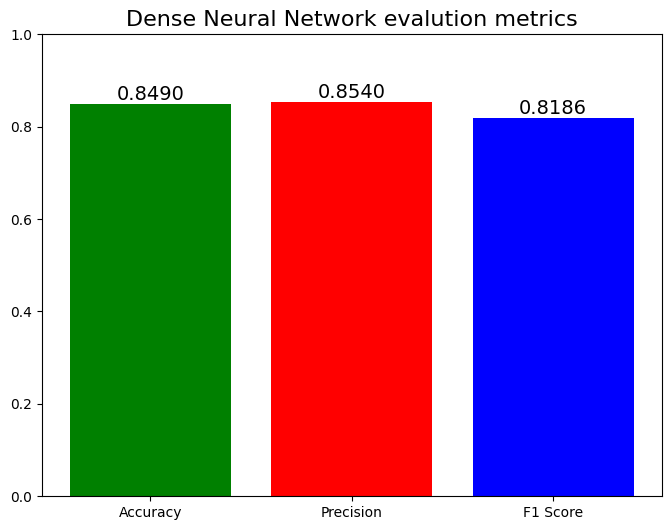

In [ ]:
width = 0.2
metric_labels = ['Accuracy', 'Precision', 'F1 Score']
metric_values = [accuracy_dnn, precision_dnn, f1_score_dnn]


plt.figure(figsize=(8,6))
bars = plt.bar(metric_labels, metric_values, color=['green', 'red', 'blue'])
plt.ylim(0,1) # y-axis (metrics) limited between 0 and 1
plt.title('Dense Neural Network evalution metrics', fontsize=16)

for bar in bars:
    height = bar.get_height() # Get bar height
    plt.text(bar.get_x() + bar.get_width() /2, # X: center of the bar
             height, # Y
             f"{height:.4f}", # value of the metric
             ha='center',
             va='bottom',
             fontsize=14)

plt.show()

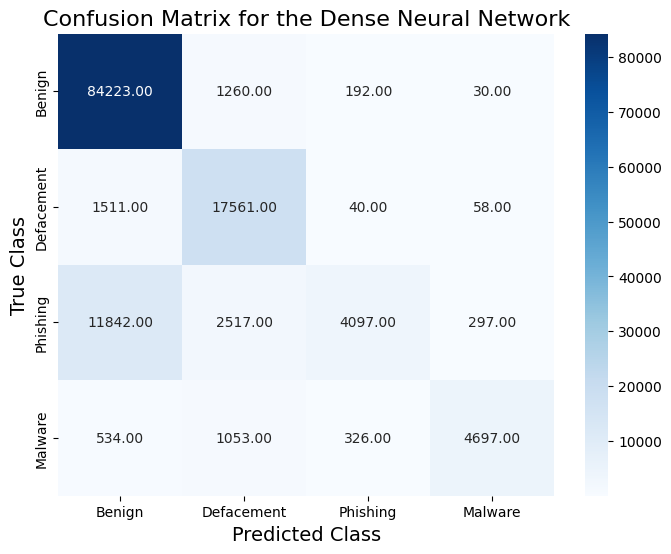

In [ ]:
#@title Plotting the Confusion Matrix for the Dense Neural Network
classes = ['Benign', 'Defacement', 'Phishing', 'Malware']

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_dnn, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Confusion Matrix for the Dense Neural Network', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.show()